### T-Period Consumption-Saving Model with Labor Supply

Solves a $T$-period consumption-saving model with endogenous labor supply and no uncertainty.

At each period $ t = 1, \dots, T $, the agent chooses consumption  $c_t$ and labor supply $\ell_t \in [0, 1] $ to maximize lifetime utility, trading off consumption gains with labor disutility:

$$
\begin{align}
V_t(a_t) &= \max_{c_t > 0, \; \ell_t \in [0,1]} \left\{ \frac{c_t^{1-\rho}}{1-\rho} - \varphi \cdot \frac{h_t^{1+\eta}}{1+\eta} + \beta \cdot V_{t+1}(a_{t+1}) \right\} \\
\text{s.t.} \quad a_{t+1} &= (1 + r).a_t + (1 - \tau) w_t \cdot h_t - c_t \\
a_t &\geq 0 \quad \text{(No borrowing)}
\end{align}
$$
### Model Parameter Settings

| **Parameter**   | **Value**                             | **Description**                             |
|------------------|-----------------------------------------|---------------------------------------------|
| `T`              | 50                                      | Number of periods                           |
| `β` (`beta`)     | 0.97                                    | Discount factor                             |
| `ρ` (`rho`)      | 1.0                                    | Relative risk aversion (CRRA)               |
| `ϕ` (`ϕ`)        | 20.0                                | Weight on utility of leisure                |
| `η` (`eta`)      | 2.0                                     | Curvature parameter for leisure utility     |
| `w`              | 12.5                                | Constant wage rate                          |
| `r`              | 0.03                                    | Interest rate                               |
| `a_max`          | 1,000,000                                 | Maximum assets in the grid                  |
| `Na`             | 30                                     | Number of asset grid points                 |
| `Nk`             | 30                                      | Number of labor supply grid points          |
| `k_grid`         | `nonlinspace(0.0, k_max, Nk, 1.1)`      | Labor supply from 0 (no work) to 1 (full)   |
| `a_grid`         | `nonlinspace(0.0, a_max, Na, 2.0)`      | Nonlinear asset grid (curved toward 0)      |
| `y`          | 5000.0   | Unearned Income                      |

### Setup

In [4]:
using Random, NLopt, LinearAlgebra, Interpolations, Base.Threads, DataFrames
using Plots, Statistics, ProgressMeter, ForwardDiff, Distributions, Profile
using DataFrames, Measures, StatsBase, LaTeXStrings, Printf

### Model

In [5]:
    # -------------------------------
    # Utility: Nonlinear Grid Creator
    # -------------------------------
    function nonlinspace(start::Float64, stop::Float64, num::Int, curv::Float64)
        lin_vals = range(0, stop=1, length=num)
        curved_vals = lin_vals .^ curv
        return start .+ (stop - start) .* curved_vals
    end


    function create_focused_grid(a_min::Float64, a_focus::Float64, a_max::Float64, Na::Int, focus_share::Float64, curv::Float64)
        # Number of points in the focus region (0 to 250,000)
        Na_focus = ceil(Int, Na * focus_share)
        # Number of points in the remaining region (250,000 to 1,000,000)
        Na_rest = Na - Na_focus
        
        # Create grid for the focus region
        grid_focus = nonlinspace(a_min, a_focus, Na_focus, curv)
        # Create grid for the upper region, excluding the duplicate point at a_focus
        grid_rest = nonlinspace(a_focus, a_max, Na_rest + 1, curv)[2:end]
        
        # Combine the two grids
        return vcat(grid_focus, grid_rest)
    end


    # -------------------------------
    # Dynamic Labor Model Definition
    # -------------------------------
    mutable struct ConSavLabor
        T::Int                        # Time periods
        rho::Float64                 # Risk aversion (CRRA)
        beta::Float64                # Discount factor
        phi::Float64                 # Weight on labor disutility
        eta::Float64                 # Frisch elasticity parameter
        alpha::Float64               # (possibly productivity or returns to labor)
        w::Float64                   # Wage rate
        y::Float64                   # unearned income
        tau::Float64                 # Labor income tax
        r::Float64                   # Interest rate
        a_max::Float64               # Max asset level
        a_min::Float64               # Min asset level
        Na::Int                      # Number of asset grid points
        k_max::Float64               # Max labor effort
        Nk::Int                      # Number of labor grid points
        simT::Int                    # Simulation time periods
        simN::Int                    # Number of simulated agents
        a_grid::Vector{Float64}      # Asset grid
        k_grid::Vector{Float64}      # Labor grid
        sol_c::Array{Float64,3}      # Optimal consumption [T, Na, Nk]
        sol_h::Array{Float64,3}      # Optimal labor effort [T, Na, Nk]
        sol_v::Array{Float64,3}      # Value function [T, Na, Nk]
        sim_c::Array{Float64,2}      # Simulated consumption [simN, simT]
        sim_h::Array{Float64,2}      # Simulated labor [simN, simT]
        sim_a::Array{Float64,2}      # Simulated assets [simN, simT]
        sim_k::Array{Float64,2}      # Simulated labor choice [simN, simT]
        sim_income::Matrix{Float64}  # Income over time (not explicitly defined in the original code)
        sim_wage::Matrix{Float64}  # Wage over time (not explicitly defined in the original code)

        sim_a_init::Vector{Float64}  # Initial assets
        sim_k_init::Vector{Float64}  # Initial labor effort
        

        draws_uniform::Array{Float64,2}  # Uniform draws for simulation [simN, simT]
        w_vec::Vector{Float64}       # Time-varying wage vector [T]
    end

    # -------------------------------
    # Constructor for ConSavLabor
    # -------------------------------
    function ConSavLabor(; T::Int=50, beta::Float64=0.97, rho::Float64=1.0, y::Float64=0.5,
                            r::Float64=0.03, a_max::Float64=15.0, Na::Int=30, simN::Int=5000,
                            a_min::Float64=0.0, k_max::Float64=30.0, Nk::Int=30,
                            w::Float64=12.5, tau::Float64=0.25,
                            eta::Float64=2.0, alpha::Float64=0.08,
                            phi::Float64=20.0, seed::Int=1234)

        # --- Time horizon and simulation settings ---
        simT = T

        # --- Grids for state variables and decisions ---
        #a_grid = nonlinspace(a_min, a_max, Na, 1.5)
        a_grid = create_focused_grid(a_min, 4.0, a_max, Na, 0.8, 1.1)
        k_grid = nonlinspace(0.0, k_max, Nk, 1.5)


        # --- Storage for solution (policy + value functions) ---
        # Dimensions: (T, Na, Nk) 
        sol_shape = (T, Na, Nk)
        sol_c = fill(NaN, sol_shape)   # Optimal consumption
        sol_h = fill(NaN, sol_shape)   # Optimal labor effort
        sol_v = fill(NaN, sol_shape)   # Value function

        # --- Simulation storage ---
        sim_shape = (simN, simT)
        sim_c = fill(NaN, sim_shape)
        sim_h = fill(NaN, sim_shape)
        sim_a = fill(NaN, sim_shape)
        sim_k = fill(NaN, sim_shape)

        # --- Random draws for simulation ---
        rng = MersenneTwister(seed)
        draws_uniform = rand(rng, sim_shape...)

        # --- Initial conditions for simulation ---
        sim_a_init = zeros(Float64, simN)
        sim_k_init = zeros(Float64, simN)
        sim_income = fill(NaN, (simN, T));  # Initialize income array for simulation
        sim_wage = fill(NaN, (simN, T));   # Initialize wage array for simulation

        # --- Wage vector (can vary by time) ---
        w_vec = fill(w, T)

        # --- Return constructed model ---
        return ConSavLabor(T, rho, beta, phi, eta, alpha, w, y, tau, r,
                            a_max, a_min, Na, k_max, Nk, simT, simN,
                            a_grid, k_grid,
                            sol_c, sol_h, sol_v,
                            sim_c, sim_h, sim_a, sim_k, sim_income, sim_wage,
                            sim_a_init, sim_k_init, draws_uniform, w_vec)
    end


ConSavLabor

In [12]:
# ------------------------------------------------
# Objective and Constraint Functions
# ------------------------------------------------

@inline function obj_last_period(model::ConSavLabor, h_vec::Vector, assets::Float64, capital::Float64, t::Int, grad::Vector)
    h = h_vec[1]
    w = wage_func(model, capital, t)
    income = w * h
    c = assets + income + model.y

    u = util(model, c, h)             # Your utility function
    du_dc = c^(-model.rho)
    du_dh = -model.phi * h^model.eta
    du_dh_total = w * du_dc + du_dh

    if length(grad) > 0
        grad[1] = du_dh_total
    end
    return u
end

@inline function obj_work_period(model::ConSavLabor, x::Vector, assets::Float64, capital::Float64, t::Int, interp, grad::Vector)
    c, h = x[1], x[2]
    w = wage_func(model, capital, t)
    income = w * h
    a_next = (1.0 + model.r) * assets + income - c + model.y
    k_next = capital + h
    V_next = interp(a_next, k_next)
    util_now = util(model, c, h)
    dutil_dc = c^(-model.rho)
    dutil_dh = -model.phi * h^model.eta

    V = util_now + model.beta * V_next
    if length(grad) > 0
        grad_V_next = Interpolations.gradient(interp, a_next, k_next)
        dV_next_da = grad_V_next[1]
        dV_next_dk = grad_V_next[2]
        dV_dc = dutil_dc - model.beta * dV_next_da
        dV_dh = dutil_dh + model.beta * (w * dV_next_da + dV_next_dk)
        grad[1] = dV_dc
        grad[2] = dV_dh
    end
    return V
end

@inline function asset_constraint(x::Vector, grad::Vector, model::ConSavLabor, assets::Float64, capital::Float64, t::Int)
    c, h = x[1], x[2]
    w = wage_func(model, capital, t)
    a_next = (1.0 + model.r) * assets + w * h + model.y - c
    g = model.a_min - a_next  # g <= 0 ensures a_next >= a_min
    if length(grad) > 0
        grad[1] = 1.0  # ∂g/∂c = -∂a_next/∂c = 1
        grad[2] = -w   # ∂g/∂h = -∂a_next/∂h = -w
    end
    return g
end

# --------------------------
# Model Solver
# --------------------------

function solve_model!(model::ConSavLabor; max_iter::Int=500)
    T, Na, Nk = model.T, model.Na, model.Nk
    a_grid, k_grid = model.a_grid, model.k_grid
    sol_c, sol_h, sol_v = model.sol_c, model.sol_h, model.sol_v

    # --- Final period (t = T) ---
    for i_a in 1:Na
        for i_k in 1:Nk
            assets = a_grid[i_a]
            capital = k_grid[i_k]
            function obj_wrapper(h_vec::Vector, grad::Vector)
                f = obj_last_period(model, h_vec, assets, capital, T, grad)
                if length(grad) > 0
                    grad[:] = -grad[:]  # Negate for minimization
                end
                return -f  # Minimize negative utility
            end
            opt = Opt(:LD_SLSQP, 1)
            lower_bounds!(opt, [0.0])
            upper_bounds!(opt, [1.0])
            ftol_rel!(opt, 1e-8)
            min_objective!(opt, obj_wrapper)
            init = [0.3]
            (minf, h_vec, ret) = optimize(opt, init)
            h_opt = h_vec[1]
            cons = assets + wage_func(model, capital, T) * h_opt + model.y
            sol_h[T, i_a, i_k] = h_opt
            sol_c[T, i_a, i_k] = cons
            sol_v[T, i_a, i_k] = -minf
        end
    end

    # --- Earlier periods (t = T-1 to 1) ---
    @showprogress 1 "Solving working model..." for t in (T-1):-1:1
        interp = create_interp(model, sol_v, t + 1)
        for i_a in 1:Na
            for i_k in 1:Nk
                assets = a_grid[i_a]
                capital = k_grid[i_k]
                function obj_wrapper(x::Vector, grad::Vector)
                    f = obj_work_period(model, x, assets, capital, t, interp, grad)
                    if length(grad) > 0
                        grad[:] = -grad[:]  # Negate for minimization
                    end
                    return -f  # Minimize negative value function
                end
                function constraint_wrapper(x::Vector, grad::Vector)
                    return asset_constraint(x, grad, model, assets, capital, t)
                end
                opt = Opt(:LD_SLSQP, 2)
                lower_bounds!(opt, [1e-8, 0.0])
                upper_bounds!(opt, [30, 1.0])
                ftol_rel!(opt, 1e-8)
                min_objective!(opt, obj_wrapper)
                inequality_constraint!(opt, constraint_wrapper, 0.0)
                init = [sol_c[t + 1, i_a, i_k], sol_h[t + 1, i_a, i_k]]
                (minf, x_opt, ret) = optimize(opt, init)
                sol_c[t, i_a, i_k] = x_opt[1]
                sol_h[t, i_a, i_k] = x_opt[2]
                sol_v[t, i_a, i_k] = -minf
            end
        end
    end
end

# ------------------------------------------------
# Supporting Functions
# ------------------------------------------------

@inline function util(model::ConSavLabor, c, h)
    if model.rho == 1.0
        cons_utility = log(c)
    else
        cons_utility = (c^(1.0 - model.rho)) / (1.0 - model.rho)
    end
    labor_disutility = model.phi * (h^(1.0 + model.eta)) / (1.0 + model.eta)
    return cons_utility - labor_disutility
end

@inline function wage_func(model::ConSavLabor, capital::Float64, t::Int)
    return (1 - model.tau) * model.w_vec[t] * (1.0 + model.alpha * capital) * 0.584
end

function create_interp(model::ConSavLabor, sol_v::Array{Float64, 3}, t::Int)
    return LinearInterpolation((model.a_grid, model.k_grid), sol_v[t, :, :], extrapolation_bc=Line())
end

create_interp (generic function with 1 method)

In [7]:
# --------------------------
# Simulation
# --------------------------
# Simulate consumption and asset paths based on the solved policy functions

function simulate_model!(model::ConSavLabor)
    simN, simT = model.simN, model.simT
    sim_a, sim_k = model.sim_a, model.sim_k
    sim_c, sim_h = model.sim_c, model.sim_h
    sim_wage, sim_income = model.sim_wage, model.sim_income
    draws_uniform = model.draws_uniform

    # Precompute interpolation objects for each period.
    # sol_c and sol_h are assumed to be 3D arrays: dimensions (T, Na, Nk)
    interp_dict = Dict()
    for t in 1:simT
        sol_c_slice = model.sol_c[t, :, :]
        sol_h_slice = model.sol_h[t, :, :]
        interp_dict[(t, :c)] = LinearInterpolation((model.a_grid, model.k_grid), sol_c_slice, extrapolation_bc=Line())
        interp_dict[(t, :h)] = LinearInterpolation((model.a_grid, model.k_grid), sol_h_slice, extrapolation_bc=Line())
    end

    # Initialize simulation with initial asset and capital conditions.
    for i in 1:simN
        sim_a[i, 1] = model.sim_a_init[i]
        sim_k[i, 1] = model.sim_k_init[i]
    end

    # Simulation loop.
    for i in 1:simN
        for t in 1:simT
            sim_c[i, t] = interp_dict[(t, :c)](sim_a[i, t], sim_k[i, t])
            sim_h[i, t] = interp_dict[(t, :h)](sim_a[i, t], sim_k[i, t])
            # Ensure hours stay in [0, 1].
            sim_h[i, t] = clamp(sim_h[i, t], 0.0, 1.0)
            # Compute wage and income for current period.
            sim_wage[i, t] = wage_func(model, sim_k[i, t], t) / 0.584
            sim_income[i, t] = wage_func(model, sim_k[i, t], t) * sim_h[i, t]
            if t < simT
                # Update next period's assets and capital.
                sim_a[i, t+1] = (1 + model.r) * sim_a[i, t] + sim_income[i, t] - sim_c[i, t] + model.y
                sim_k[i, t+1] = sim_k[i, t] + sim_h[i, t]
            end
        end
    end
end


simulate_model! (generic function with 1 method)

### Labor Supply Elasticity Analysis

The code computes labor supply elasticity with respect to wage changes in a `ConSavLabor` model by comparing average labor supply (`h`) under a baseline wage and a perturbed wage (`w * (1 + Δw_frac)`), for `Δw_frac = [0.01, 0.05, 0.08]`. It tests scenarios with `alpha = [0, 0.08]` (productivity effect) and `y = [0, 8000]` (unearned income), presenting results in a table.

In [8]:
using Random, NamedTupleTools, DataFrames

# Define the compute_elasticity function (unchanged)
function compute_elasticity(model_params::NamedTuple, Δw_frac::Float64; seed::Int=1234)
    rng = MersenneTwister(seed)
    
    # Baseline model
    model_baseline = ConSavLabor(; model_params...)
    solve_model!(model_baseline)
    simulate_model!(model_baseline)
    h_baseline = mean(model_baseline.sim_h)
    
    # Perturbed model (wage increased by Δw_frac)
    w_perturbed = model_params.w * (1 + Δw_frac)
    perturbed_params = merge(model_params, (w = w_perturbed,))
    model_perturbed = ConSavLabor(; perturbed_params...)
    solve_model!(model_perturbed)
    simulate_model!(model_perturbed)
    h_perturbed = mean(model_perturbed.sim_h)
    
    # Compute elasticity
    elasticity = (h_perturbed - h_baseline) / h_baseline / Δw_frac
    return elasticity
end

# Define base model parameters (unchanged)
base_params = (alpha = 0.08, y = 8000.0, w = 12.5, T = 50, beta = 0.97, rho = 1.0, 
               r = 0.03, a_max = 100000.0, Na = 30, simN = 5000, a_min = 0.0, 
               k_max = 30.0, Nk = 30, tau = 0.25, eta = 2.0, phi = 20.0)

# Define scenarios
alphas = [0.0, 0.08]
ys = [0.0, 8000.0]
Δw_frac_values = [0.01, 0.05, 0.08]

# Initialize a DataFrame with corrected column names
column_names = ["Δw_frac", "α=0, y=0", "α=0, y=8000", "α=0.08, y=0", "α=0.08, y=8000"]
results = DataFrame([Float64[] for _ in 1:length(column_names)], column_names)

# Compute elasticities for each Δw_frac and scenario
for Δw in Δw_frac_values
    row = [Δw]
    for alpha in alphas
        for y in ys
            # Update model parameters for the scenario
            scenario_params = merge(base_params, (alpha = alpha, y = y))
            elasticity = compute_elasticity(scenario_params, Δw)
            push!(row, elasticity)
        end
    end
    push!(results, row)
end

# Print the results table
results

3×5 DataFrame
 Row │ Δw_frac  α=0, y=0      α=0, y=8000  α=0.08, y=0   α=0.08, y=8000 
     │ Float64  Float64       Float64      Float64       Float64        
─────┼──────────────────────────────────────────────────────────────────
   1 │    0.01  -1.2657e-9          1.0    -0.000530821         1.00023
   2 │    0.05  -2.03416e-9         1.0    -1.27137e-7          1.00023
   3 │    0.08  -8.75435e-10      659.542  -5.41334e-8        663.176

### Model and Counterfactual Simulation in a T-Period 
This script solves and simulates a finite-horizon (T-period) consumption-saving model under different economic scenarios. It compares a baseline model with four counterfactual experiments, focusing on how each setting affects average consumption and asset accumulation over time.


In [13]:
# ============================
# Baseline and Counterfactuals
# ============================
rng = MersenneTwister(1234)
# -- Baseline Model (Default Parameters) --
model_baseline = ConSavLabor(alpha = 0.08, y=0.50)
model_baseline.sim_a_init .= rand(rng, model_baseline.simN) .* 10;
solve_model!(model_baseline)
simulate_model!(model_baseline)

# ----------------------------------------
# Counterfactual 1: Tax Rate Variations
# ----------------------------------------

# Lower tax rate (τ = 10%)
model_low_tax = ConSavLabor(alpha = 0.08, y=0.50, tau = 0.15)
model_low_tax.sim_a_init .= rand(rng, model_low_tax.simN) .* 10;
solve_model!(model_low_tax)
simulate_model!(model_low_tax)

# Higher tax rate (τ = 30%)
model_high_tax = ConSavLabor(alpha = 0.08, y=0.50, tau = 0.4)
model_high_tax.sim_a_init .= rand(rng, model_high_tax.simN) .* 10;
solve_model!(model_high_tax)
simulate_model!(model_high_tax)

# ----------------------------------------
# Counterfactual 2: Wage Variations
# ----------------------------------------

# Higher wage level (w = 150,000)
model_high_wage = ConSavLabor(w = 20.0)
solve_model!(model_high_wage)
simulate_model!(model_high_wage)

# ----------------------------------------
# Counterfactual 3: Time Preference (Discount Factor β)
# ----------------------------------------

# More impatient agent (β = 0.95)
model_low_beta = ConSavLabor(beta = 0.95)
solve_model!(model_low_beta)
simulate_model!(model_low_beta)

# More patient agent (β = 0.99)
model_high_beta = ConSavLabor(beta = 0.99)
solve_model!(model_high_beta)
simulate_model!(model_high_beta)

# ----------------------------------------
# Counterfactual 4: Frisch Elasticity (η)
# ----------------------------------------

# Higher Frisch elasticity (η = 3.0 → more responsive labor supply)
model_high_fe = ConSavLabor(eta = 3.0)
solve_model!(model_high_fe)
simulate_model!(model_high_fe)

# Lower Frisch elasticity (η = 7.0 → less responsive labor supply)
model_low_fe = ConSavLabor(eta = 7.0)
solve_model!(model_low_fe)
simulate_model!(model_low_fe)

# ----------------------------------------
# Counterfactual 5: Initial Assets from Lognormal Distribution
# ----------------------------------------
# Assign initial assets from a LogNormal distribution with ~90% falling between $5k and $20k
μ = 9.4
σ = 0.45

model_lognormal = ConSavLabor()
model_lognormal.sim_a_init .= rand(LogNormal(μ, σ), model_lognormal.simN)./ 10000
solve_model!(model_lognormal)
simulate_model!(model_lognormal)

model_uniform = ConSavLabor()
model_uniform.sim_a_init .= rand(rng, model_uniform.simN) .* 20
solve_model!(model_uniform)
simulate_model!(model_uniform)

# ----------------------------------------
# Counterfactual 7: Interest Rate Variations (r)
# ----------------------------------------

# Lower interest rate (r = 2%)
model_low_r = ConSavLabor(r = 0.02)
solve_model!(model_low_r)
simulate_model!(model_low_r)


# Higher interest rate (r = 5%)
model_high_r = ConSavLabor(r = 0.05)
solve_model!(model_high_r)
simulate_model!(model_high_r)


### Model Structure and Policy Function Visualization

- **Asset Grid (Top-left):**  
  Displays the nonlinear asset grid, with denser points at low asset levels.

- **Terminal Value Function (Top-right):**  
Depicts the value function at \(T = 50\), representing lifetime utility as a function of assets.

- **Terminal Consumption Policy (Middle-left):**  
  Shows optimal consumption at the terminal period (\(T = 50\)), where agents consume all available resources.

- **Early Consumption Policy (Middle-right):**  
  Illustrates optimal consumption at an earlier period (\(T = 10\)), reflecting saving behavior.

- **Early Labor Policy (Bottom-left):**  
  Displays optimal labor supply at \(T = 10\).

- **Terminal Labor Policy (Bottom-right):**  
  Shows optimal labor supply at \(T = 50\).

This layout clarifies how the asset grid design and time dynamics shape optimal consumption and labor decisions.

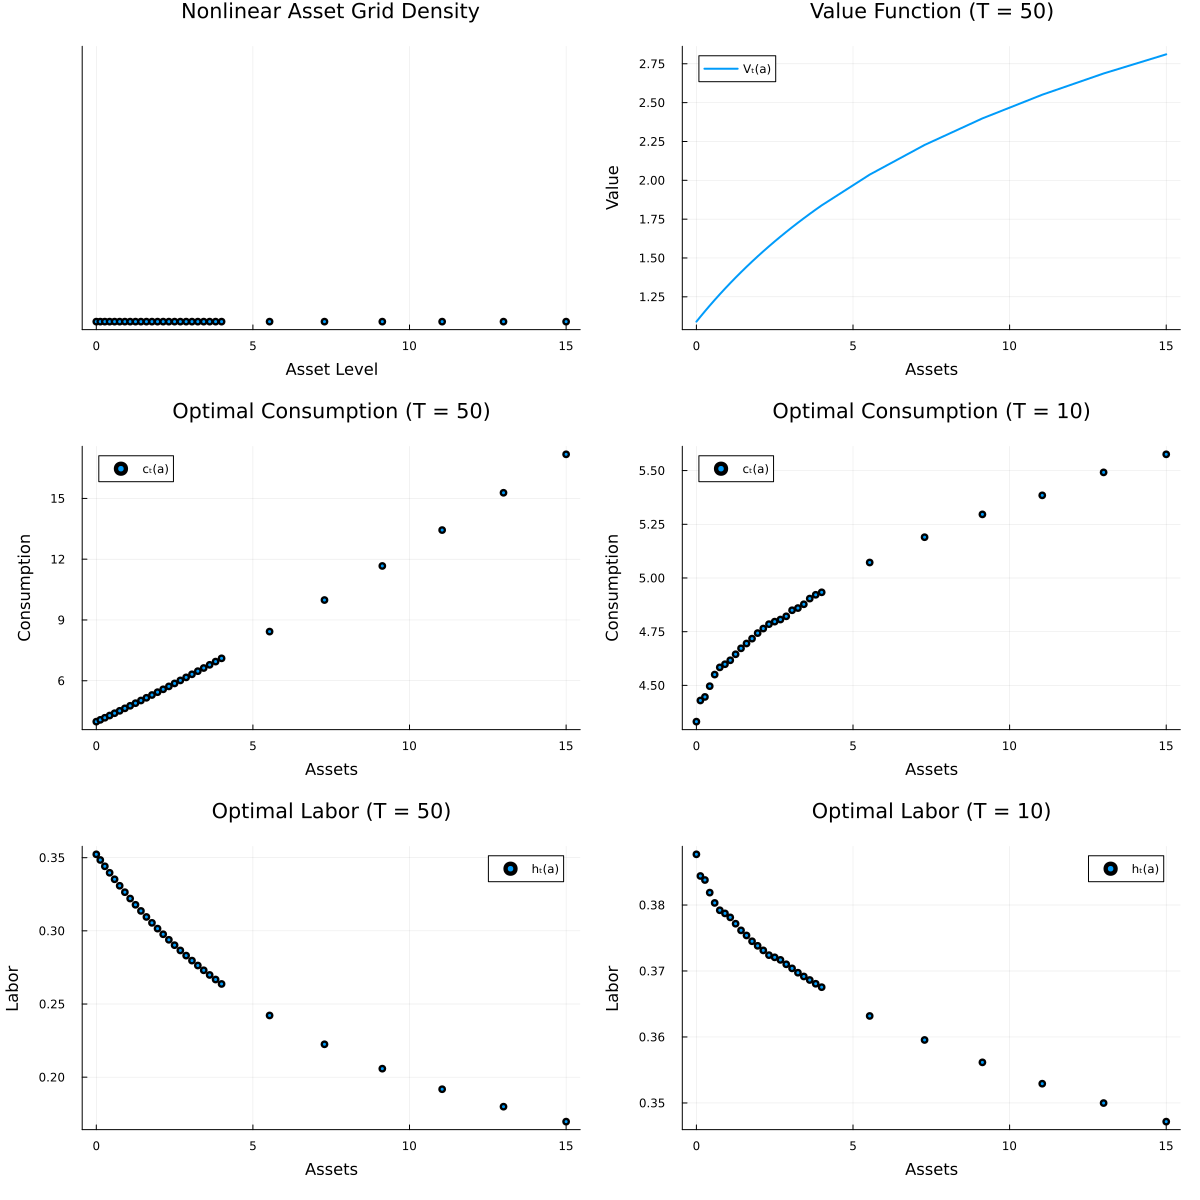

In [14]:

# Choose a representative labor grid index (e.g. the median)
k_mid = Int(ceil(length(model_baseline.k_grid)/2))
T_terminal = model_baseline.T  # Terminal period (e.g., 50)
t_early = 10          # An earlier period for comparison

# 1. Plot the nonlinear asset grid
p1 = scatter(model_baseline.a_grid, zeros(length(model_baseline.a_grid)),
    xlabel = "Asset Level",
    yticks = [],
    title = "Nonlinear Asset Grid Density",
    markersize = 3,
    legend = false)

# 2. Plot optimal consumption policy at terminal period (T = model.T)
# Here we fix the labor dimension at k_mid.
p2 = scatter(model_baseline.a_grid, model_baseline.sol_c[T_terminal, :, k_mid],
    xlabel = "Assets",
    ylabel = "Consumption",
    title = "Optimal Consumption (T = $(T_terminal))",
    label = "cₜ(a)",
    markersize = 3)

# 3. Plot value function at terminal period (T = model.T)
# Note: use 'sol_v' (not sol_V) as per your definition.
p3 = plot(model_baseline.a_grid, model_baseline.sol_v[T_terminal, :, k_mid],
    xlabel = "Assets",
    ylabel = "Value",
    title = "Value Function (T = $(T_terminal))",
    label = "Vₜ(a)",
    linewidth = 2)

# 4. Plot optimal consumption policy at an earlier period (e.g., T = 10)
p4 = scatter(model_baseline.a_grid, model_baseline.sol_c[t_early, :, k_mid],
    xlabel = "Assets",
    ylabel = "Consumption",
    title = "Optimal Consumption (T = $(t_early))",
    label = "cₜ(a)",
    markersize = 3)

p5 = scatter(model_baseline.a_grid, model_baseline.sol_h[t_early, :, k_mid],
    xlabel = "Assets",
    ylabel = "Labor",
    title = "Optimal Labor (T = $(t_early))",
    label = "hₜ(a)",
    markersize = 3)

p6 = scatter(model_baseline.a_grid, model_baseline.sol_h[T_terminal, :, k_mid],
    xlabel = "Assets",
    ylabel = "Labor",
    title = "Optimal Labor (T = $(T_terminal))",
    label = "hₜ(a)",
    markersize = 3)

# Combine all plots into a 2×2 grid layout for comparison
plot(p1, p3, p2, p4, p6, p5, layout = (3, 2), size = (1200, 1200), margin=3mm)

###  Counterfactual Analysis
We investigate the effects of key economic parameters on individual consumption, savings, labor effort, and human capital accumulation. Our **baseline model** is defined as follows:


In [49]:
t = 1:model_baseline.simT

function extract_all(model)
    return (
        c = mean(model.sim_c, dims=1)[:] .* 10,
        a = mean(model.sim_a, dims=1)[:] .* 10,
        h = mean(model.sim_h, dims=1)[:],
        k = mean(model.sim_k, dims=1)[:],
        income = mean(model.sim_income, dims=1)[:] .* 10,
        wage = mean(model.sim_wage, dims=1)[:]
    )
end


extract_all (generic function with 1 method)

##### Counterfactual 1: **Tax Rate Variations**

We vary the labor income tax rate to examine its impact on work incentives and savings behavior.

- **Baseline:** τ = 0.25
- **Low Tax:** τ = 0.10
- **High Tax:** τ = 0.30 

> 💡 **Interpretation:**  
> Lower taxes increase disposable income, which leads to higher consumption and more asset accumulation. Higher taxes reduce both, while increasing labor disincentives.


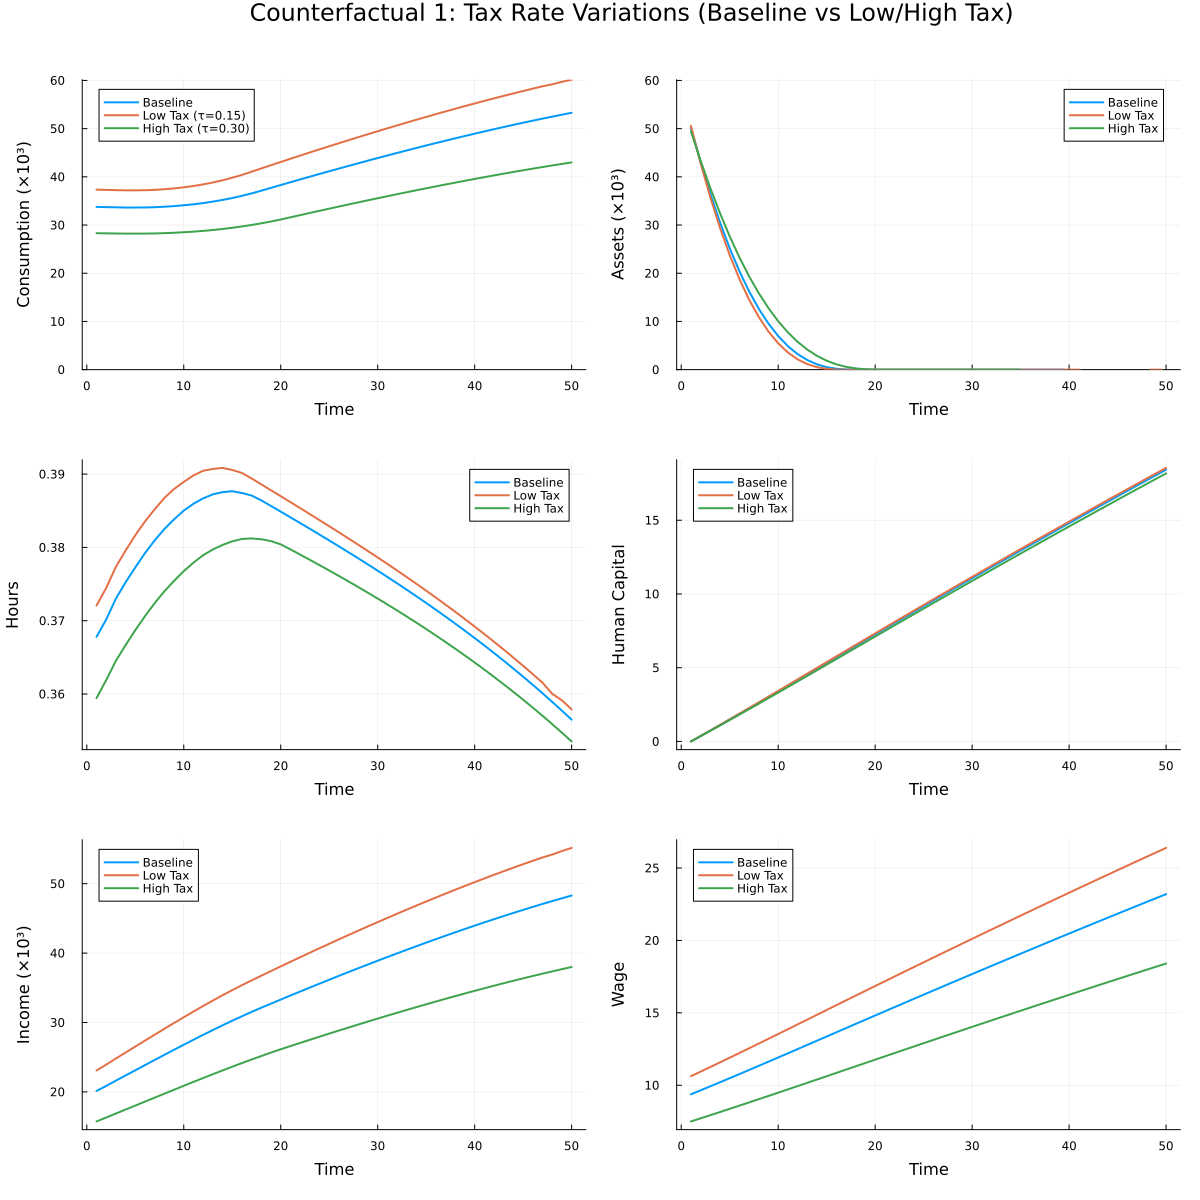

In [50]:
# ----------------------------------------------
# 1. Tax Rate Variations (Low and High Tax)
# ----------------------------------------------

thousand_formatter = (val -> @sprintf("%.0f", val/1_000))

# Extract data for each scenario
base = extract_all(model_baseline)
low_tax = extract_all(model_low_tax)
high_tax = extract_all(model_high_tax)

# Time vector (assuming t is defined, e.g., t = 1:model_baseline.T)
t = 1:length(base.c)  # Adjust based on your model's time horizon
ymax_c = maximum(vcat(base.c, low_tax.c, high_tax.c))
# Plot 1: Consumption
p1 = plot(t, base.c, label="Baseline", lw=2, xlabel="Time", ylabel="Consumption (×10³)",
            ylims=(0, ymax_c))
plot!(p1, t, low_tax.c, label="Low Tax (τ=0.15)", lw=2)
plot!(p1, t, high_tax.c, label="High Tax (τ=0.30)", lw=2)
#plot!(p1, yformatter=thousand_formatter)

# Plot 2: Assets
ymax_a = maximum(vcat(base.a, low_tax.a, high_tax.a, ymax_c))
p2 = plot(t, base.a, label="Baseline", lw=2, xlabel="Time", ylabel="Assets (×10³)",
            ylims=(0, ymax_a))
plot!(p2, t, low_tax.a, label="Low Tax", lw=2)
plot!(p2, t, high_tax.a, label="High Tax", lw=2)
#plot!(p2, yformatter=thousand_formatter)

# Plot 3: Hours
p3 = plot(t, base.h, label="Baseline", lw=2, xlabel="Time", ylabel="Hours")
            #ylims=(0.2, 0.4))
plot!(p3, t, low_tax.h, label="Low Tax", lw=2)
plot!(p3, t, high_tax.h, label="High Tax", lw=2)

# Plot 4: Human Capital
p4 = plot(t, base.k, label="Baseline", lw=2, xlabel="Time", ylabel="Human Capital")
plot!(p4, t, low_tax.k, label="Low Tax", lw=2)
plot!(p4, t, high_tax.k, label="High Tax", lw=2)

# Plot 5: Income
p5 = plot(t, base.income, label="Baseline", lw=2, xlabel="Time", ylabel="Income (×10³)")
plot!(p5, t, low_tax.income, label="Low Tax", lw=2)
plot!(p5, t, high_tax.income, label="High Tax", lw=2)
#plot!(p5, yformatter=thousand_formatter)

# Plot 6: Hourly Wage
p6 = plot(t, base.wage, label="Baseline", lw=2, xlabel="Time", ylabel="Wage")
plot!(p6, t, low_tax.wage, label="Low Tax", lw=2)
plot!(p6, t, high_tax.wage, label="High Tax", lw=2)


# Combine into a 3x2 layout
combined_plot = plot(p1, p2, p3, p4, p5, p6,
                     layout=(3, 2),
                     size=(1200, 1200),
                     plot_title="Counterfactual 1: Tax Rate Variations (Baseline vs Low/High Tax)",
                     titlefont=16,
                     margin=3mm)

##### Counterfactual 2: **Wage Variations**

We increase the wage rate to study the response in labor effort, income, and savings.

- **Baseline:** w = 100,000  
- **High Wage:** w = 150,000  

> 💡 **Interpretation:**  
> A higher wage raises labor income and thus consumption and wealth, with little change in hours worked due to offsetting income and substitution effects.


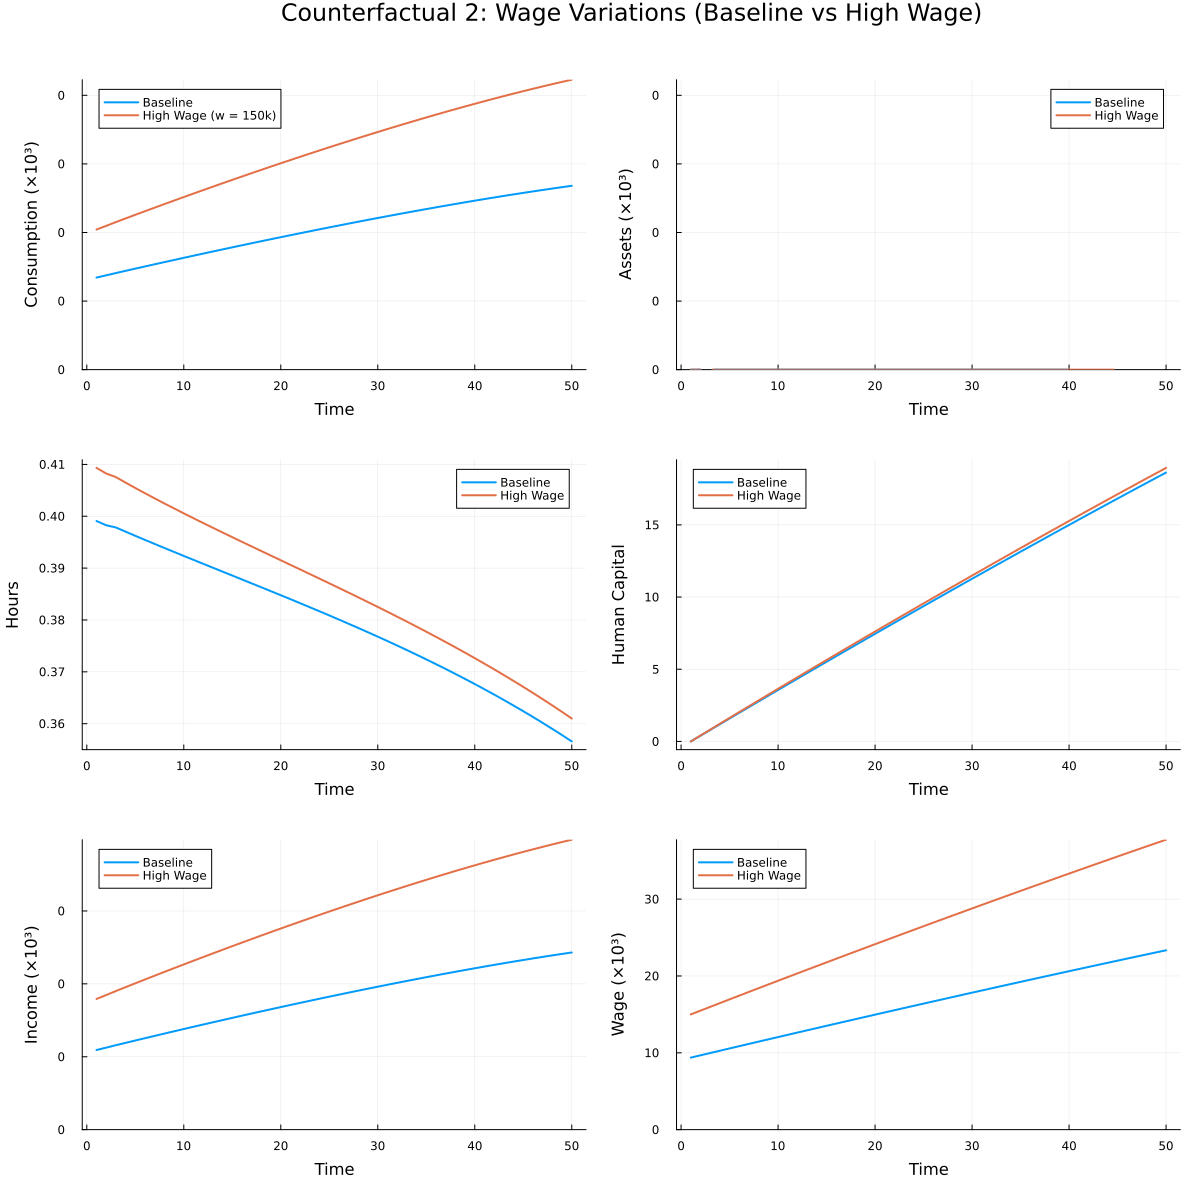

In [51]:
model_baseline = ConSavLabor(alpha = 0.08, y = 0.5)
model_baseline.sim_a_init .= 0;
solve_model!(model_baseline)
simulate_model!(model_baseline)

# ----------------------------------------------
# 2. Wage Variations (Baseline vs High Wage)
# ----------------------------------------------

# Formatter for monetary values
thousand_formatter = (val -> @sprintf("%.0f", val / 1_000))

# Extract data
high_wage = extract_all(model_high_wage)
base = extract_all(model_baseline)
# Time vector
t = 1:length(base.c)

# Max values for consistent y-limits
ymax_c = maximum(vcat(base.c, high_wage.c))
ymax_a = maximum(vcat(base.a, high_wage.a, ymax_c))
ymax_income = maximum(vcat(base.income, high_wage.income))
ymax_wage = maximum(vcat(base.wage, high_wage.wage))

# Plot 1: Consumption
p1 = plot(t, base.c, label="Baseline", lw=2, xlabel="Time", ylabel="Consumption (×10³)", ylims=(0, ymax_c))
plot!(p1, t, high_wage.c, label="High Wage (w = 150k)", lw=2)
plot!(p1, yformatter=thousand_formatter)

# Plot 2: Assets
p2 = plot(t, base.a, label="Baseline", lw=2, xlabel="Time", ylabel="Assets (×10³)", ylims=(0, ymax_a))
plot!(p2, t, high_wage.a, label="High Wage", lw=2)
plot!(p2, yformatter=thousand_formatter)

# Plot 3: Hours
p3 = plot(t, base.h, label="Baseline", lw=2, xlabel="Time", ylabel="Hours")
plot!(p3, t, high_wage.h, label="High Wage", lw=2)

# Plot 4: Human Capital
p4 = plot(t, base.k, label="Baseline", lw=2, xlabel="Time", ylabel="Human Capital")
plot!(p4, t, high_wage.k, label="High Wage", lw=2)

# Plot 5: Income
p5 = plot(t, base.income, label="Baseline", lw=2, xlabel="Time", ylabel="Income (×10³)", ylims=(0, ymax_income))
plot!(p5, t, high_wage.income, label="High Wage", lw=2)
plot!(p5, yformatter=thousand_formatter)

# Plot 6: Wage
p6 = plot(t, base.wage, label="Baseline", lw=2, xlabel="Time", ylabel="Wage (×10³)", ylims=(0, ymax_wage))
plot!(p6, t, high_wage.wage, label="High Wage", lw=2)


# Combine into a 3x2 layout
combined_plot_2 = plot(p1, p2, p3, p4, p5, p6,
                       layout=(3, 2),
                       size=(1200, 1200),
                       plot_title="Counterfactual 2: Wage Variations (Baseline vs High Wage)",
                       titlefont=16,
                       margin=3mm)

##### Counterfactual 3: **Discount Factor Variations (Time Preference)**

We vary the discount factor $ \beta $ to analyze how patience affects consumption, savings, and labor supply behavior over the life cycle.

- **Baseline:** $ \beta = 0.97 $  
- **Low Beta:** $ \beta = 0.96 $ (more impatient)  
- **High Beta:** $ \beta = 0.98 $ (more patient)

> 💡 **Interpretation:**  
> A **lower $\beta$** leads to more present-oriented behavior—individuals **consume more early on**, **save less**, and **work more** to fund current consumption.  
> A **higher $\beta$** implies stronger future orientation—people **defer consumption**, **save more**, and **may work less** due to greater accumulated wealth.



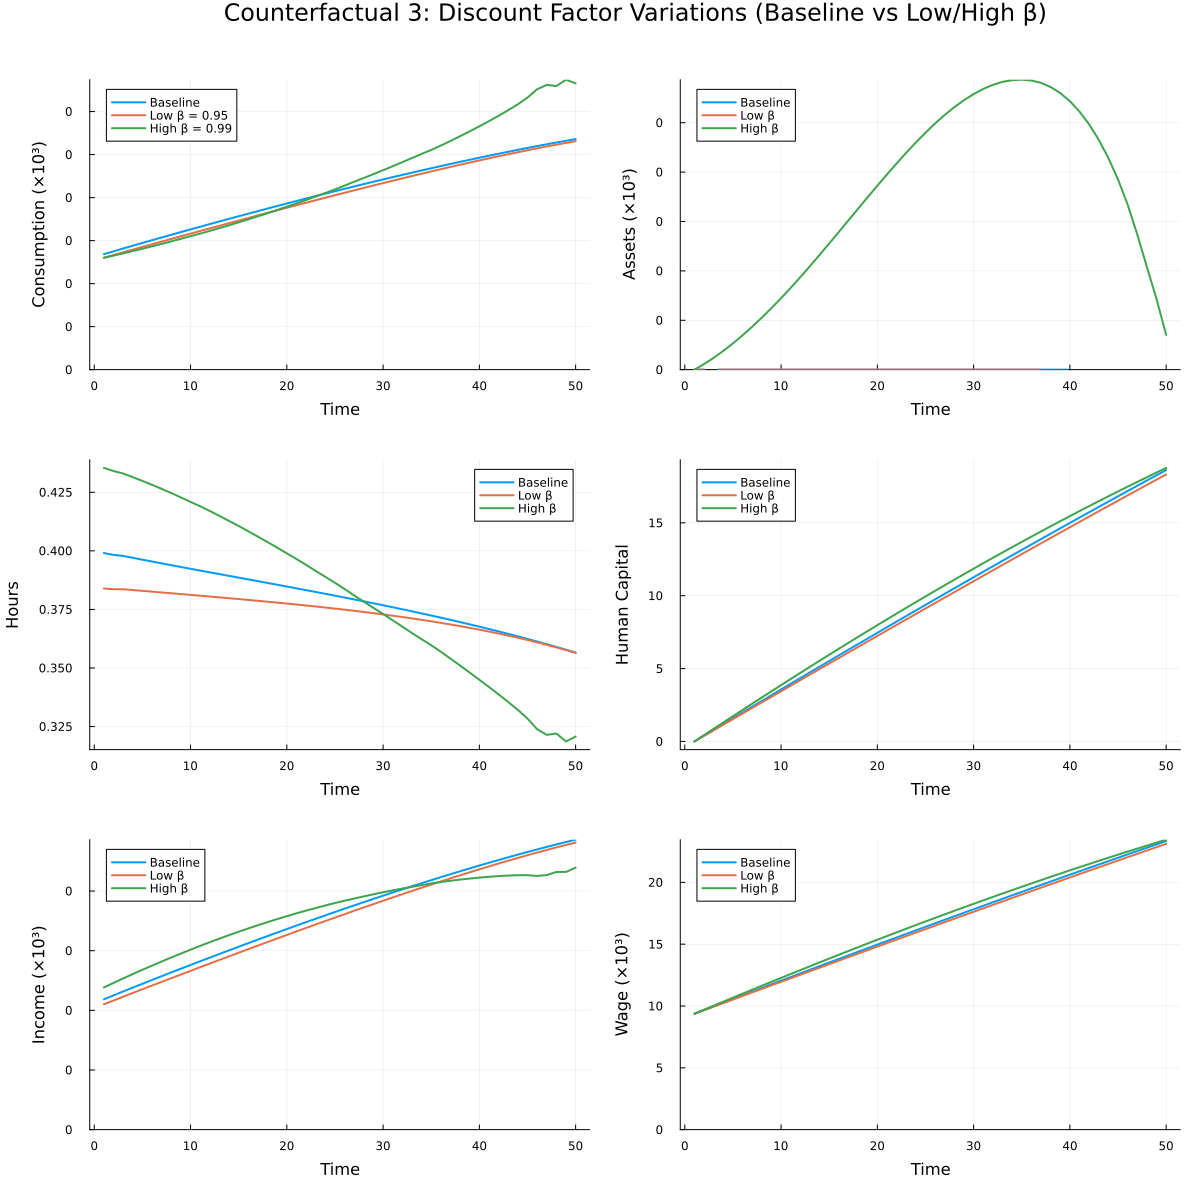

In [52]:
# ----------------------------------------------
# 3. Discount Factor Variations (Low and High β)
# ----------------------------------------------

# Extract simulated series
low_beta  = extract_all(model_low_beta)
high_beta = extract_all(model_high_beta)

# Time vector
t = 1:length(base.c)

# Max values for y-limits
ymax_c = maximum(vcat(base.c, low_beta.c, high_beta.c))
ymax_a = maximum(vcat(base.a, low_beta.a, high_beta.a, ymax_c))  # keep ymax_c as instructed
ymax_income = maximum(vcat(base.income, low_beta.income, high_beta.income))
ymax_wage = maximum(vcat(base.wage, low_beta.wage, high_beta.wage))

# Formatter for monetary values
thousand_formatter = (val -> @sprintf("%.0f", val / 1_000))

# Plot 1: Consumption
p1 = plot(t, base.c, label="Baseline", lw=2, xlabel="Time", ylabel="Consumption (×10³)", ylims=(0, ymax_c))
plot!(p1, t, low_beta.c, label="Low β = 0.95", lw=2)
plot!(p1, t, high_beta.c, label="High β = 0.99", lw=2)
plot!(p1, yformatter=thousand_formatter)

# Plot 2: Assets
p2 = plot(t, base.a, label="Baseline", lw=2, xlabel="Time", ylabel="Assets (×10³)", ylims=(0, ymax_a))
plot!(p2, t, low_beta.a, label="Low β", lw=2)
plot!(p2, t, high_beta.a, label="High β", lw=2)
plot!(p2, yformatter=thousand_formatter)

# Plot 3: Hours
p3 = plot(t, base.h, label="Baseline", lw=2, xlabel="Time", ylabel="Hours")
plot!(p3, t, low_beta.h, label="Low β", lw=2)
plot!(p3, t, high_beta.h, label="High β", lw=2)

# Plot 4: Human Capital
p4 = plot(t, base.k, label="Baseline", lw=2, xlabel="Time", ylabel="Human Capital")
plot!(p4, t, low_beta.k, label="Low β", lw=2)
plot!(p4, t, high_beta.k, label="High β", lw=2)

# Plot 5: Income
p5 = plot(t, base.income, label="Baseline", lw=2, xlabel="Time", ylabel="Income (×10³)", ylims=(0, ymax_income))
plot!(p5, t, low_beta.income, label="Low β", lw=2)
plot!(p5, t, high_beta.income, label="High β", lw=2)
plot!(p5, yformatter=thousand_formatter)

# Plot 6: Wage
p6 = plot(t, base.wage, label="Baseline", lw=2, xlabel="Time", ylabel="Wage (×10³)", ylims=(0, ymax_wage))
plot!(p6, t, low_beta.wage, label="Low β", lw=2)
plot!(p6, t, high_beta.wage, label="High β", lw=2)


# Combine all plots in a 3x2 layout
combined_plot_3 = plot(p1, p2, p3, p4, p5, p6,
                       layout=(3, 2),
                       size=(1200, 1200),
                       plot_title="Counterfactual 3: Discount Factor Variations (Baseline vs Low/High β)",
                       titlefont=16,
                       margin=3mm)

##### Counterfactual 4: **Frisch Elasticity**

We vary the elasticity of labor supply (η) and the disutility weight of working (φ).

- **Baseline:** η = 5.0
- **High Frisch Elasticity:** η = 3.0 
- **Low Frisch Elasticity:** η = 7.0

> 💡 **Interpretation:**  
> A lower η implies a more elastic labor supply—agents respond more to wage changes.


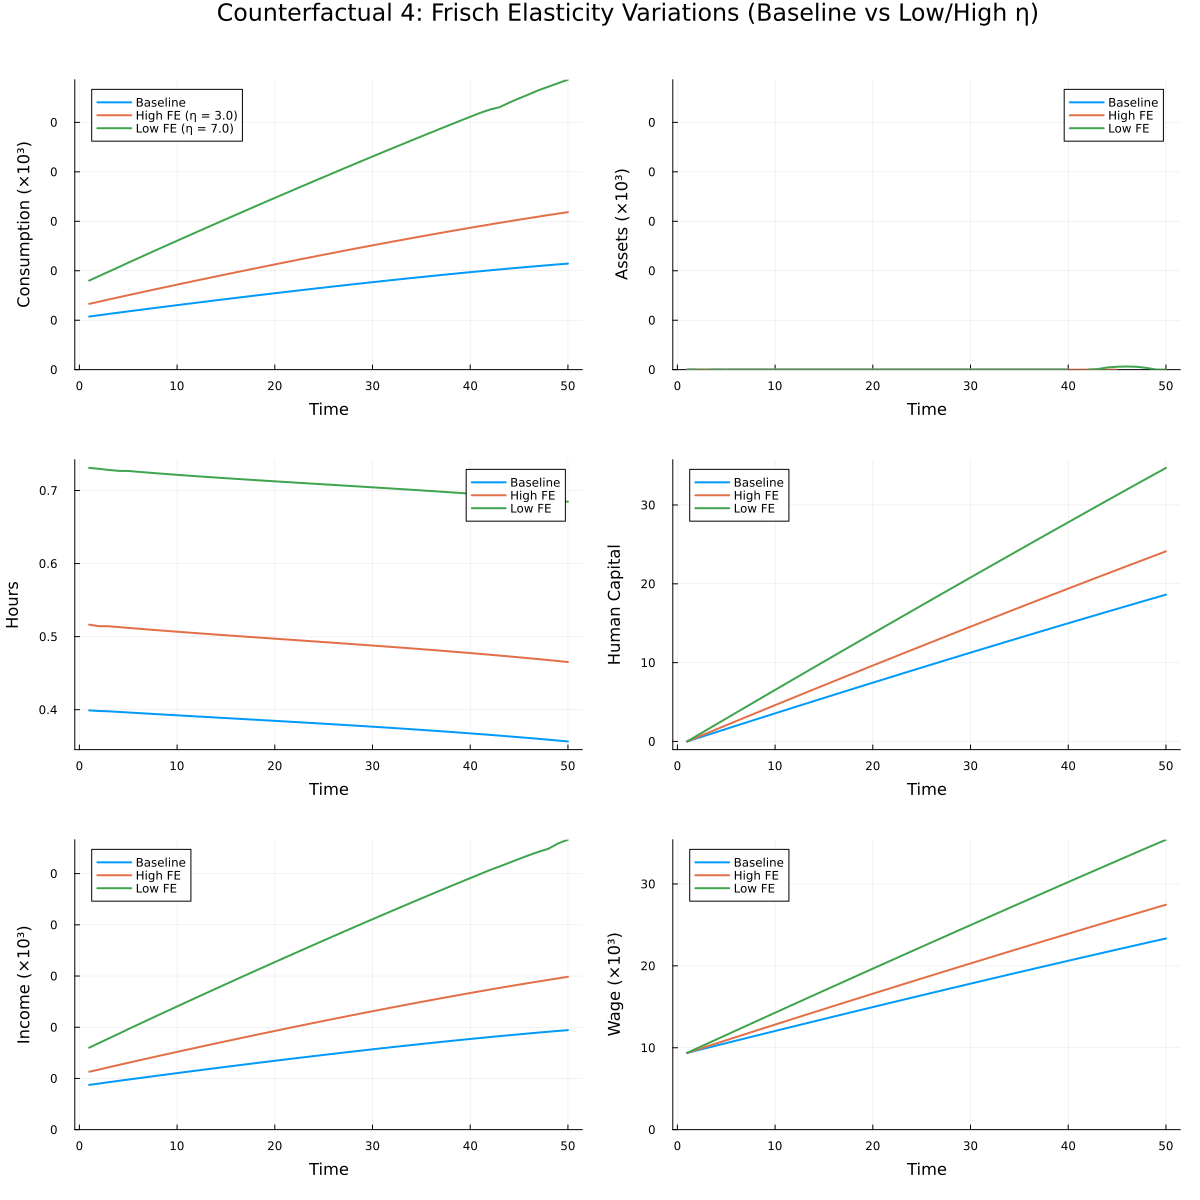

In [53]:
# ----------------------------------------------
# 4. Frisch Elasticity (η)
# ----------------------------------------------

# Extract data
high_fe = extract_all(model_high_fe)
low_fe = extract_all(model_low_fe)

# Time vector
t = 1:length(base.c)

# Max values for y-limits
ymax_c = maximum(vcat(base.c, high_fe.c, low_fe.c))
ymax_a = maximum(vcat(base.a, high_fe.a, low_fe.a, ymax_c))  # keep ymax_c in asset range
ymax_income = maximum(vcat(base.income, high_fe.income, low_fe.income))
ymax_wage = maximum(vcat(base.wage, high_fe.wage, low_fe.wage))

# Formatter
thousand_formatter = (val -> @sprintf("%.0f", val / 1_000))

# Plot 1: Consumption
p1 = plot(t, base.c, label="Baseline", lw=2, xlabel="Time", ylabel="Consumption (×10³)", ylims=(0, ymax_c))
plot!(p1, t, high_fe.c, label="High FE (η = 3.0)", lw=2)
plot!(p1, t, low_fe.c, label="Low FE (η = 7.0)", lw=2)
plot!(p1, yformatter=thousand_formatter)

# Plot 2: Assets
p2 = plot(t, base.a, label="Baseline", lw=2, xlabel="Time", ylabel="Assets (×10³)", ylims=(0, ymax_a))
plot!(p2, t, high_fe.a, label="High FE", lw=2)
plot!(p2, t, low_fe.a, label="Low FE", lw=2)
plot!(p2, yformatter=thousand_formatter)

# Plot 3: Hours
p3 = plot(t, base.h, label="Baseline", lw=2, xlabel="Time", ylabel="Hours")
plot!(p3, t, high_fe.h, label="High FE", lw=2)
plot!(p3, t, low_fe.h, label="Low FE", lw=2)

# Plot 4: Human Capital
p4 = plot(t, base.k, label="Baseline", lw=2, xlabel="Time", ylabel="Human Capital")
plot!(p4, t, high_fe.k, label="High FE", lw=2)
plot!(p4, t, low_fe.k, label="Low FE", lw=2)

# Plot 5: Income
p5 = plot(t, base.income, label="Baseline", lw=2, xlabel="Time", ylabel="Income (×10³)", ylims=(0, ymax_income))
plot!(p5, t, high_fe.income, label="High FE", lw=2)
plot!(p5, t, low_fe.income, label="Low FE", lw=2)
plot!(p5, yformatter=thousand_formatter)

# Plot 6: Wage
p6 = plot(t, base.wage, label="Baseline", lw=2, xlabel="Time", ylabel="Wage (×10³)", ylims=(0, ymax_wage))
plot!(p6, t, high_fe.wage, label="High FE", lw=2)
plot!(p6, t, low_fe.wage, label="Low FE", lw=2)


# Combine into 3x2 layout
combined_plot_4 = plot(p1, p2, p3, p4, p5, p6,
                       layout=(3, 2),
                       size=(1200, 1200),
                       plot_title="Counterfactual 4: Frisch Elasticity Variations (Baseline vs Low/High η)",
                       titlefont=16,
                       margin=3mm)

##### Counterfactual 5: **Initial Asset Distribution**

We introduce heterogeneity in initial wealth by drawing from a lognormal distribution.

- **Baseline:** Initial assets = 0  
- **Counterfactual:** Initial assets ∼ LogNormal(μ = 9.4, σ = 0.45; ~90% to fall between 5,000 and 20,000)

> 💡 **Interpretation:**  
> Agents starting with more wealth consume more and work slightly less early in life. Their asset accumulation path is flatter compared to the baseline.

---


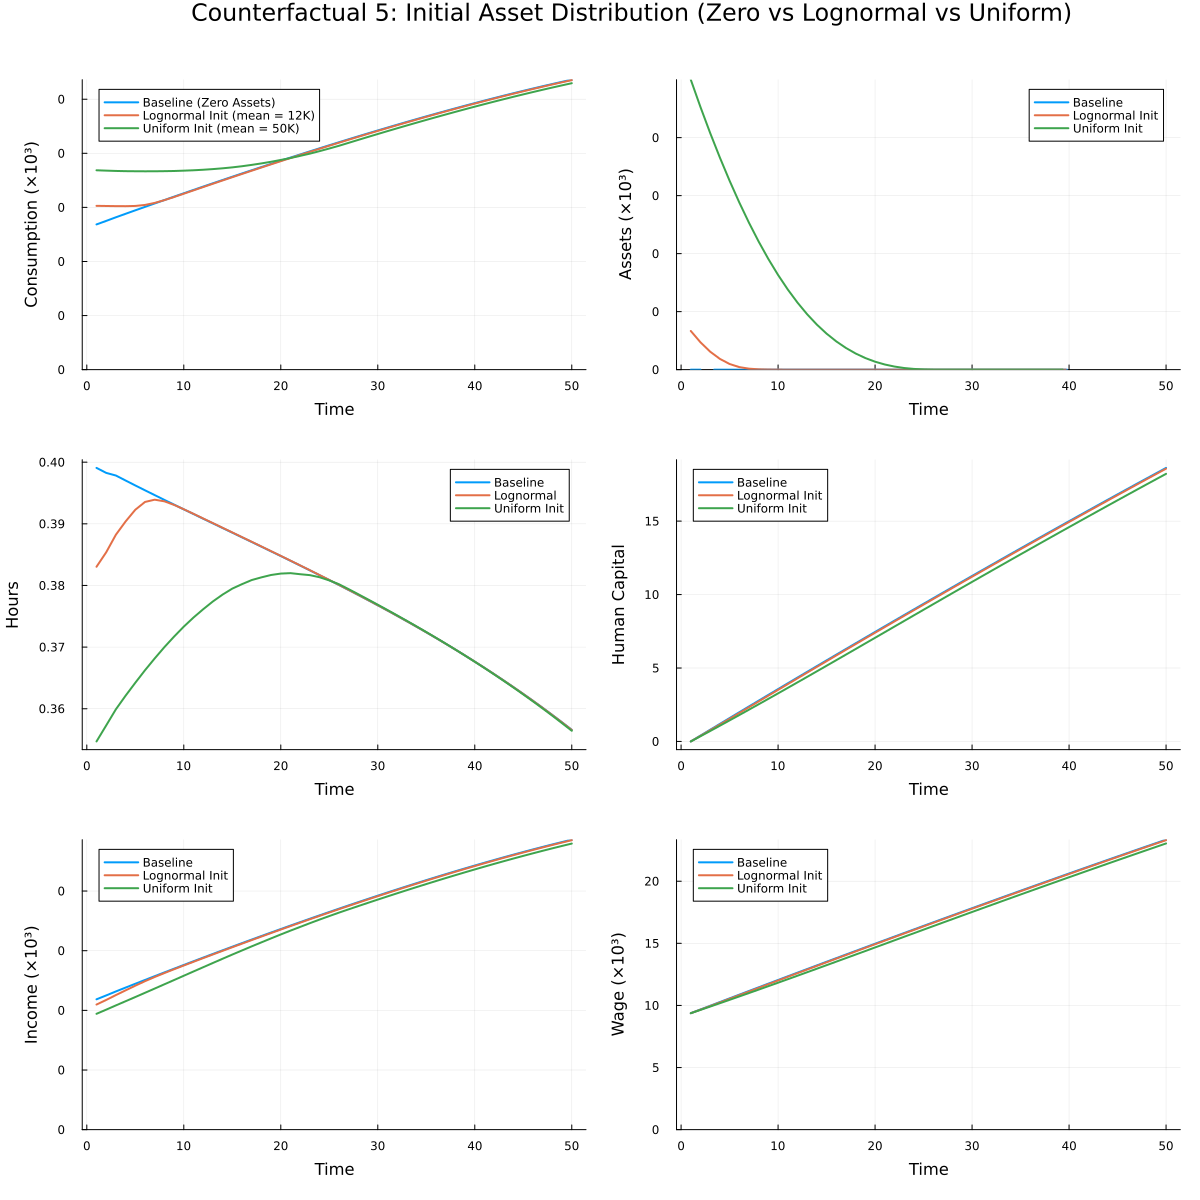

In [54]:
# ----------------------------------------------
# 5. Initial Asset Distribution (Zero vs Lognormal vs Uniform)
# ----------------------------------------------

# Extract data
lognorm = extract_all(model_lognormal)
uniform = extract_all(model_uniform)

# Time vector
t = 1:length(base.c)

# Max values for y-limits
ymax_c = maximum(vcat(base.c, lognorm.c, uniform.c))
ymax_a = maximum(vcat(base.a, lognorm.a, uniform.a, ymax_c))  # including ymax_c as before
ymax_income = maximum(vcat(base.income, lognorm.income, uniform.income))
ymax_wage = maximum(vcat(base.wage, lognorm.wage, uniform.wage))

# Formatter
thousand_formatter = (val -> @sprintf("%.0f", val / 1_000))

# Plot 1: Consumption
p1 = plot(t, base.c, label="Baseline (Zero Assets)", lw=2, xlabel="Time", ylabel="Consumption (×10³)", ylims=(0, ymax_c))
plot!(p1, t, lognorm.c, label="Lognormal Init (mean = 12K)", lw=2)
plot!(p1, t, uniform.c, label="Uniform Init (mean = 50K)", lw=2)
plot!(p1, yformatter=thousand_formatter)

# Plot 2: Assets
p2 = plot(t, base.a, label="Baseline", lw=2, xlabel="Time", ylabel="Assets (×10³)", ylims=(0, ymax_a))
plot!(p2, t, lognorm.a, label="Lognormal Init", lw=2)
plot!(p2, t, uniform.a, label="Uniform Init", lw=2)
plot!(p2, yformatter=thousand_formatter)

# Plot 3: Hours
p3 = plot(t, base.h, label="Baseline", lw=2, xlabel="Time", ylabel="Hours")
plot!(p3, t, lognorm.h, label="Lognormal", lw=2)
plot!(p3, t, uniform.h, label="Uniform Init", lw=2)

# Plot 4: Human Capital
p4 = plot(t, base.k, label="Baseline", lw=2, xlabel="Time", ylabel="Human Capital")
plot!(p4, t, lognorm.k, label="Lognormal Init", lw=2)
plot!(p4, t, uniform.k, label="Uniform Init", lw=2)

# Plot 5: Income
p5 = plot(t, base.income, label="Baseline", lw=2, xlabel="Time", ylabel="Income (×10³)", ylims=(0, ymax_income))
plot!(p5, t, lognorm.income, label="Lognormal Init", lw=2)
plot!(p5, t, uniform.income, label="Uniform Init", lw=2)
plot!(p5, yformatter=thousand_formatter)

# Plot 6: Wage
p6 = plot(t, base.wage, label="Baseline", lw=2, xlabel="Time", ylabel="Wage (×10³)", ylims=(0, ymax_wage))
plot!(p6, t, lognorm.wage, label="Lognormal Init", lw=2)
plot!(p6, t, uniform.wage, label="Uniform Init", lw=2)


# Combine into 3x2 layout
combined_plot_5 = plot(p1, p2, p3, p4, p5, p6,
                       layout=(3, 2),
                       size=(1200, 1200),
                       plot_title="Counterfactual 5: Initial Asset Distribution (Zero vs Lognormal vs Uniform)",
                       titlefont=16,
                       margin=3mm)

##### Counterfactual 6: **Retirement Income Reduction**

We simulate a drop in labor income during the later stages of the life cycle to approximate retirement. Specifically, we assume that after period 40, wages fall to 70% of their original level.

- **Baseline:** Constant wage $ w $ throughout life  
- **Retirement Scenario:** $ w_t = 0.7w $ for $ t \geq 40 $

> 💡 **Interpretation:**  
> As wages decline post-retirement, individuals **reduce consumption**, **draw down savings**, and **work fewer hours** if feasible.  
> The model captures lifecycle behavior such as **asset decumulation** and **increased reliance on prior savings** to smooth consumption in retirement.

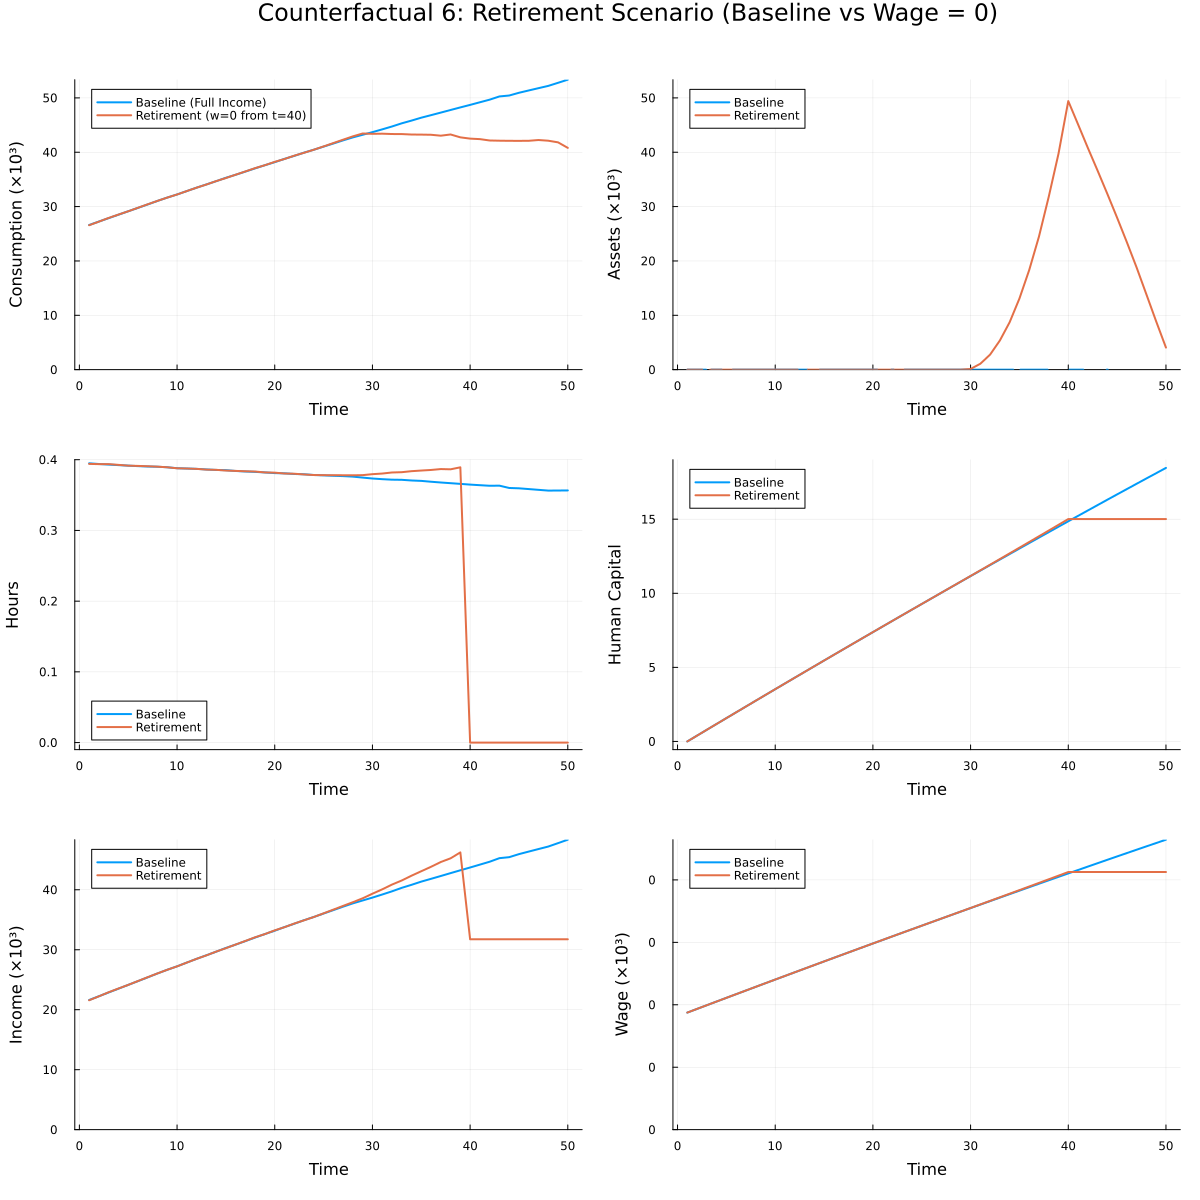

In [10]:
# ----------------------------------------------
# 6. Retirement Scenario (Baseline vs Wage = 0)
# ----------------------------------------------

# Extract simulation data
base   = extract_all(model_baseline)     # Full income every period
retire = extract_all(model_baseline_retire)   # Wage drops to 0 from t = 40

# Time vector
t = 1:length(base.c)

# Max values for y-limits
ymax_c = maximum(vcat(base.c, retire.c))
ymax_a = maximum(vcat(base.a, retire.a, ymax_c))  # keep ymax_c for asset scaling
ymax_income = maximum(vcat(base.income, retire.income))
ymax_wage = maximum(vcat(base.wage, retire.wage))

# Formatter for monetary variables
thousand_formatter = (val -> @sprintf("%.0f", val / 1_000))

# Plot 1: Consumption
p1 = plot(t, base.c, label="Baseline (Full Income)", lw=2, xlabel="Time", ylabel="Consumption (×10³)", ylims=(0, ymax_c))
plot!(p1, t, retire.c, label="Retirement (w=0 from t=40)", lw=2)
plot!(p1, yformatter=thousand_formatter)

# Plot 2: Assets
p2 = plot(t, base.a, label="Baseline", lw=2, xlabel="Time", ylabel="Assets (×10³)", ylims=(0, ymax_a))
plot!(p2, t, retire.a, label="Retirement", lw=2)
plot!(p2, yformatter=thousand_formatter)

# Plot 3: Hours
p3 = plot(t, base.h, label="Baseline", lw=2, xlabel="Time", ylabel="Hours", ylims=(-0.01, 0.4))
plot!(p3, t, retire.h, label="Retirement", lw=2)

# Plot 4: Human Capital
p4 = plot(t, base.k, label="Baseline", lw=2, xlabel="Time", ylabel="Human Capital")
plot!(p4, t, retire.k, label="Retirement", lw=2)

# Plot 5: Income
p5 = plot(t, base.income, label="Baseline", lw=2, xlabel="Time", ylabel="Income (×10³)", ylims=(0, ymax_income))
plot!(p5, t, retire.income, label="Retirement", lw=2)
plot!(p5, yformatter=thousand_formatter)

# Plot 6: Wage
p6 = plot(t, base.wage, label="Baseline", lw=2, xlabel="Time", ylabel="Wage (×10³)", ylims=(0, ymax_wage))
plot!(p6, t, retire.wage, label="Retirement", lw=2)
plot!(p6, yformatter=thousand_formatter)

# Combine into 3x2 layout
combined_plot_6 = plot(p1, p2, p3, p4, p5, p6,
                       layout=(3, 2),
                       size=(1200, 1200),
                       plot_title="Counterfactual 6: Retirement Scenario (Baseline vs Wage = 0)",
                       titlefont=16,
                       margin=3mm)

##### Counterfactual 7: **Interest Rate Variations**

We alter the interest rate $ r $ to understand how the return on savings influences household decisions.

- **Baseline:** $ r = 3\% $  
- **Low r:** $ r = 1\% $  
- **High r:** $ r = 5\% $

> 💡 **Interpretation:**  
> A **higher interest rate** increases the return on saving, encouraging **greater asset accumulation** and potentially **lower labor supply** due to income effects.  
> A **lower interest rate** reduces the incentive to save, leading to **lower wealth** and possibly **higher labor supply** to maintain consumption levels.

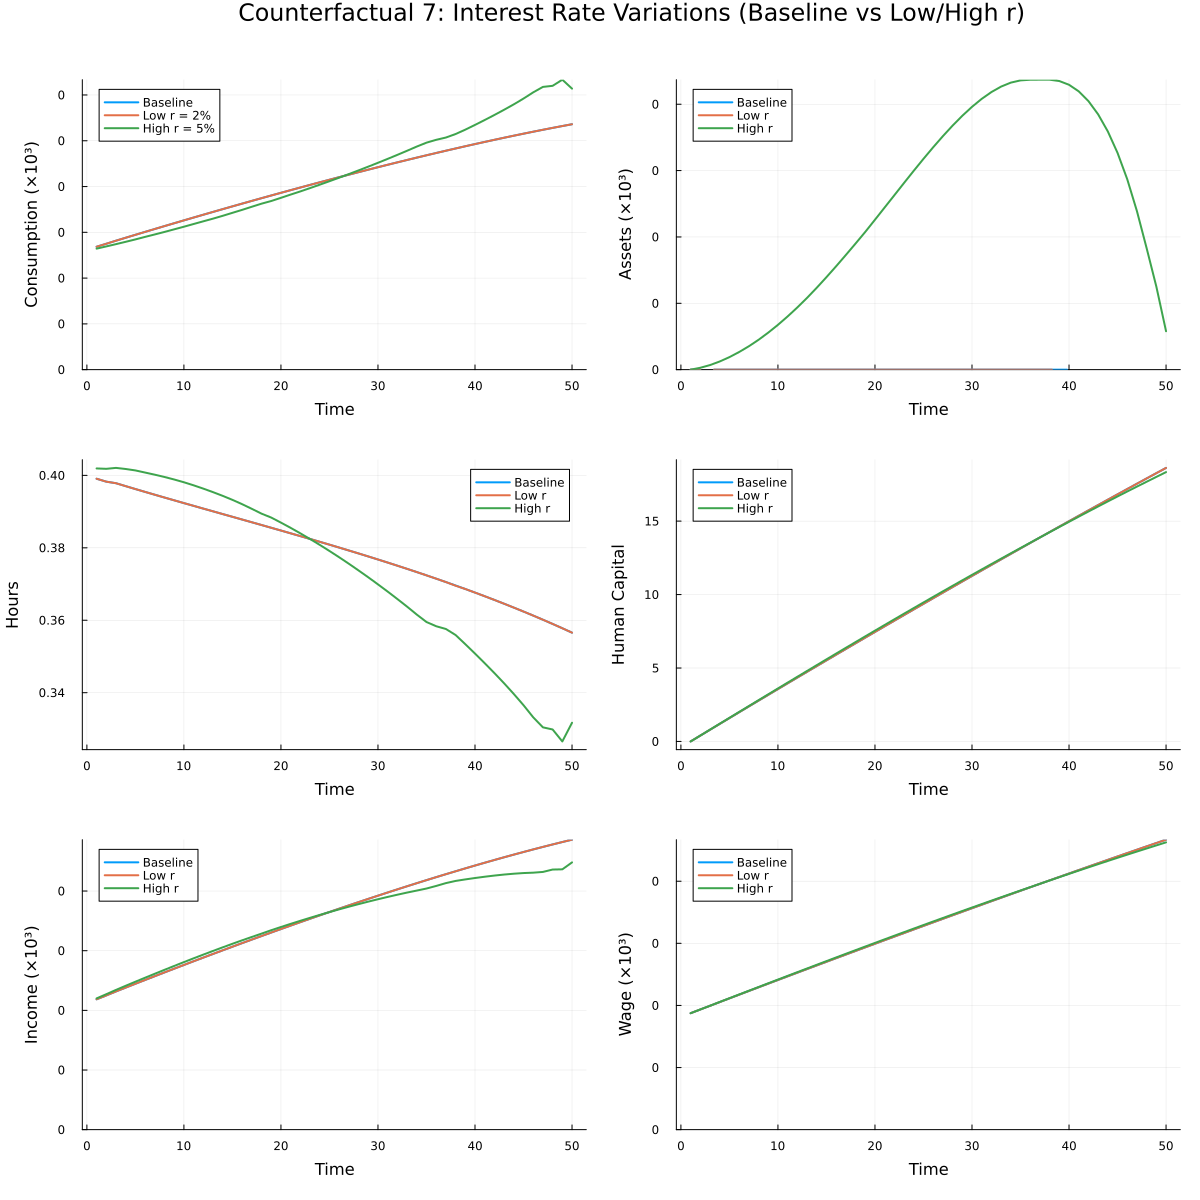

In [56]:
# ----------------------------------------------
# 7. Interest Rate Variations (Baseline vs Low/High r)
# ----------------------------------------------

# Extract simulated series
low_r  = extract_all(model_low_r)
high_r = extract_all(model_high_r)

# Time vector
t = 1:length(base.c)

# Max values for y-limits
ymax_c = maximum(vcat(base.c, low_r.c, high_r.c))
ymax_a = maximum(vcat(base.a, low_r.a, high_r.a, ymax_c))  # include ymax_c
ymax_income = maximum(vcat(base.income, low_r.income, high_r.income))
ymax_wage = maximum(vcat(base.wage, low_r.wage, high_r.wage))

# Formatter
thousand_formatter = (val -> @sprintf("%.0f", val / 1_000))

# Plot 1: Consumption
p1 = plot(t, base.c, label="Baseline", lw=2, xlabel="Time", ylabel="Consumption (×10³)", ylims=(0, ymax_c))
plot!(p1, t, low_r.c, label="Low r = 2%", lw=2)
plot!(p1, t, high_r.c, label="High r = 5%", lw=2)
plot!(p1, yformatter=thousand_formatter)

# Plot 2: Assets
p2 = plot(t, base.a, label="Baseline", lw=2, xlabel="Time", ylabel="Assets (×10³)", ylims=(0, ymax_a))
plot!(p2, t, low_r.a, label="Low r", lw=2)
plot!(p2, t, high_r.a, label="High r", lw=2)
plot!(p2, yformatter=thousand_formatter)

# Plot 3: Hours
p3 = plot(t, base.h, label="Baseline", lw=2, xlabel="Time", ylabel="Hours")
plot!(p3, t, low_r.h, label="Low r", lw=2)
plot!(p3, t, high_r.h, label="High r", lw=2)

# Plot 4: Human Capital
p4 = plot(t, base.k, label="Baseline", lw=2, xlabel="Time", ylabel="Human Capital")
plot!(p4, t, low_r.k, label="Low r", lw=2)
plot!(p4, t, high_r.k, label="High r", lw=2)

# Plot 5: Income
p5 = plot(t, base.income, label="Baseline", lw=2, xlabel="Time", ylabel="Income (×10³)", ylims=(0, ymax_income))
plot!(p5, t, low_r.income, label="Low r", lw=2)
plot!(p5, t, high_r.income, label="High r", lw=2)
plot!(p5, yformatter=thousand_formatter)

# Plot 6: Wage
p6 = plot(t, base.wage, label="Baseline", lw=2, xlabel="Time", ylabel="Wage (×10³)", ylims=(0, ymax_wage))
plot!(p6, t, low_r.wage, label="Low r", lw=2)
plot!(p6, t, high_r.wage, label="High r", lw=2)
plot!(p6, yformatter=thousand_formatter)

# Combine into 3x2 layout
combined_plot_7 = plot(p1, p2, p3, p4, p5, p6,
                       layout=(3, 2),
                       size=(1200, 1200),
                       plot_title="Counterfactual 7: Interest Rate Variations (Baseline vs Low/High r)",
                       titlefont=16,
                       margin=3mm)

In [6]:
# -------------------------------
# Utility: Nonlinear Grid Creator
# -------------------------------
function nonlinspace(start::Float64, stop::Float64, num::Int, curv::Float64)
    lin_vals = range(0, stop=1, length=num)
    curved_vals = lin_vals .^ curv
    return start .+ (stop - start) .* curved_vals
end


function create_focused_grid(a_min::Float64, a_focus::Float64, a_max::Float64, Na::Int, focus_share::Float64, curv::Float64)
    # Number of points in the focus region (0 to 250,000)
    Na_focus = ceil(Int, Na * focus_share)
    # Number of points in the remaining region (250,000 to 1,000,000)
    Na_rest = Na - Na_focus
    
    # Create grid for the focus region
    grid_focus = nonlinspace(a_min, a_focus, Na_focus, curv)
    # Create grid for the upper region, excluding the duplicate point at a_focus
    grid_rest = nonlinspace(a_focus, a_max, Na_rest + 1, curv)[2:end]
    
    # Combine the two grids
    return vcat(grid_focus, grid_rest)
end


# -------------------------------
# Dynamic Labor Model Definition
# -------------------------------
mutable struct ConSavLabor_retirement
    T::Int                        # Time periods
    rho::Float64                 # Risk aversion (CRRA)
    beta::Float64                # Discount factor
    phi::Float64                 # Weight on labor disutility
    eta::Float64                 # Frisch elasticity modelameter
    alpha::Float64               # (possibly productivity or returns to labor)
    w::Float64                   # Wage rate
    y::Float64                   # Non-labor income
    tau::Float64                 # Labor income tax
    r::Float64                   # Interest rate
    a_max::Float64               # Max asset level
    a_min::Float64               # Min asset level
    Na::Int                      # Number of asset grid points
    k_max::Float64               # Max labor effort
    Nk::Int                      # Number of labor grid points
    simT::Int                    # Simulation time periods
    simN::Int                    # Number of simulated agents
    a_grid::Vector{Float64}      # Asset grid
    k_grid::Vector{Float64}      # Labor grid
    sol_c::Array{Float64,3}      # Optimal consumption [T, Na, Nk]
    sol_h::Array{Float64,3}      # Optimal labor effort [T, Na, Nk]
    sol_v::Array{Float64,3}      # Value function [T, Na, Nk]
    sim_c::Array{Float64,2}      # Simulated consumption [simN, simT]
    sim_h::Array{Float64,2}      # Simulated labor [simN, simT]
    sim_a::Array{Float64,2}      # Simulated assets [simN, simT]
    sim_k::Array{Float64,2}      # Simulated labor choice [simN, simT]
    sim_income::Matrix{Float64}  # Income over time (not explicitly defined in the original code)
    sim_wage::Matrix{Float64}  # Wage over time (not explicitly defined in the original code)

    sim_a_init::Vector{Float64}  # Initial assets
    sim_k_init::Vector{Float64}  # Initial labor effort
    

    draws_uniform::Array{Float64,2}  # Uniform draws for simulation [simN, simT]
    w_vec::Vector{Float64}      # Wage vector (can vary by time)
    t_retire::Int                # Retirement time
    h_avg::Float64               # Average labor effort (initialized to 0)
end  

# -------------------------------
# Constructor for ConSavLabor_retirement
# -------------------------------
function ConSavLabor_retirement(; T::Int=50, beta::Float64=0.97, rho::Float64=1.0, y=5000.0,
                                r::Float64=0.03, a_max::Float64=150000.0, Na::Int=30, simN::Int=5000,
                                a_min::Float64=0.0, k_max::Float64=30.0, Nk::Int=30,
                                w::Float64=12.5, tau::Float64=0.25,
                                eta::Float64=2.0, alpha::Float64=0.08,
                                phi::Float64=20.0, seed::Int=1234, t_retire::Int=40, h_avg::Float64=0.11)

    # --- Time horizon and simulation settings ---
    simT = T

    # --- Grids for state variables and decisions ---
    #a_grid = nonlinspace(a_min, a_max, Na, 1.5)
    a_grid = create_focused_grid(a_min, 40000.0, a_max, Na, 0.8, 1.1)
    k_grid = nonlinspace(0.0, k_max, Nk, 1.5)


    # --- Storage for solution (policy + value functions) ---
    # Dimensions: (T, Na, Nk) 
    sol_shape = (T, Na, Nk)
    sol_c = fill(NaN, sol_shape)   # Optimal consumption
    sol_h = fill(NaN, sol_shape)   # Optimal labor effort
    sol_v = fill(NaN, sol_shape)   # Value function

    # --- Simulation storage ---
    sim_shape = (simN, simT)
    sim_c = fill(NaN, sim_shape)
    sim_h = fill(NaN, sim_shape)
    sim_a = fill(NaN, sim_shape)
    sim_k = fill(NaN, sim_shape)

    # --- Random draws for simulation ---
    rng = MersenneTwister(seed)
    draws_uniform = rand(rng, sim_shape...)

    # --- Initial conditions for simulation ---
    sim_a_init = zeros(Float64, simN)
    sim_k_init = zeros(Float64, simN)
    sim_income = fill(NaN, (simN, T));  # Initialize income array for simulation
    sim_wage = fill(NaN, (simN, T));   # Initialize wage array for simulation

    # --- Wage vector (can vary by time) ---
    w_vec = fill(w, T)

    # --- Return constructed model ---
    return ConSavLabor_retirement(T, rho, beta, phi, eta, alpha, w, y, tau, r,
                          a_max, a_min, Na, k_max, Nk, simT, simN,
                          a_grid, k_grid,
                          sol_c, sol_h, sol_v,
                          sim_c, sim_h, sim_a, sim_k, sim_income, sim_wage,
                          sim_a_init, sim_k_init, draws_uniform, w_vec, t_retire, h_avg)
end

function solve_model!(model::ConSavLabor_retirement)
    T, Na, Nk = model.T, model.Na, model.Nk
    a_grid, k_grid = model.a_grid, model.k_grid
    sol_c, sol_h, sol_v = model.sol_c, model.sol_h, model.sol_v
    t_retire, h_avg = model.t_retire, model.h_avg

    # --- Final period (t = T), during retirement ---
    for i_a in 1:Na
        for i_k in 1:Nk
            assets = a_grid[i_a]
            capital = k_grid[i_k]
            pension = 0.7 * wage_func(model, capital, T) * h_avg 
            #pension = 0.0  # No labor income in retirement
            cons = assets + pension + model.y # Consume all resources
            sol_h[T, i_a, i_k] = 0.0
            sol_c[T, i_a, i_k] = cons
            sol_v[T, i_a, i_k] = util(model, cons, 0.0)
        end
    end

    # --- Retirement periods (t = T-1 to t_retire) ---
    @showprogress 1 "Solving retirement periods..." for t in (T-1):-1:t_retire
        interp = create_interp(model, sol_v, t + 1)
        for i_a in 1:Na
            for i_k in 1:Nk
                assets = a_grid[i_a]
                capital = k_grid[i_k]
                pension = 0.7 * wage_func(model, capital, t) * h_avg
                #pension = 0.0  # No labor income in retirement
                function obj_retire(c::Float64)
                    a_next = (1.0 + model.r) * assets + pension - c + model.y
                    k_next = capital  # h = 0
                    V_next = interp(a_next, k_next)
                    penalty_c = c < 0.0 ? (abs(c)^2) * 1.0e7 : 0.0
                    penalty_a = a_next < model.a_min ? ((model.a_min - a_next)^2) * 1.0e10 : 0.0
                    return -(util(model, c, 0.0) + model.beta * V_next - penalty_c - penalty_a)
                end
                opt = Opt(:LN_COBYLA, 1)
                lower_bounds!(opt, [1e-6])
                upper_bounds!(opt, [model.a_max])  # Adjust as needed
                min_objective!(opt, (c_vec, grad) -> obj_retire(c_vec[1]))
                init = [sol_c[t + 1, i_a, i_k]]
                (minf, c_opt, ret) = optimize(opt, init)
                sol_c[t, i_a, i_k] = c_opt[1]
                sol_h[t, i_a, i_k] = 0.0
                sol_v[t, i_a, i_k] = -minf
            end
        end
    end

    # --- Working periods (t = t_retire - 1 to 1) ---
    @showprogress 1 "Solving working periods..." for t in (t_retire - 1):-1:1
        interp = create_interp(model, sol_v, t + 1)
        for i_a in 1:Na
            for i_k in 1:Nk
                assets = a_grid[i_a]
                capital = k_grid[i_k]
                function obj_work(x::Vector, grad::Vector)
                    c, h = x[1], x[2]
                    return -value_of_work_choice(model, c, h, assets, capital, t, interp)
                end
                opt = Opt(:LN_COBYLA, 2)
                lower_bounds!(opt, [1e-6, 0.0])
                upper_bounds!(opt, [Inf, 1.0])
                ftol_rel!(opt, 1e-8)
                min_objective!(opt, obj_work)
                init = [sol_c[t + 1, i_a, i_k], sol_h[t + 1, i_a, i_k]]
                (minf, x_opt, ret) = optimize(opt, init)
                sol_c[t, i_a, i_k] = x_opt[1]
                sol_h[t, i_a, i_k] = x_opt[2]
                sol_v[t, i_a, i_k] = -minf
            end
        end
    end

    return model
end

function value_of_work_choice(model::ConSavLabor_retirement, c::Float64, h::Float64, assets::Float64,
    capital::Float64, t::Int, interp)
    penalty_c = c < 0.0 ? (abs(c)^2) * 1.0e5 : 0.0  # Reduced from 1.0e7
    penalty_h = h < 0.0 ? (abs(h)^2) * 1.0e5 : 0.0
    income = wage_func(model, capital, t) * h
    a_next = (1.0 + model.r) * assets + income - c + model.y
    penalty_a = a_next < model.a_min ? ((model.a_min - a_next)^2) * 1.0e7 : 0.0
    util_now = util(model, c, h)
    k_next = capital + h
    V_next = interp(a_next, k_next)
    return util_now + model.beta * V_next - penalty_a - penalty_c - penalty_h
end






# ------------------------------------------------
# Supporting functions 
# ------------------------------------------------



@inline function util(model::ConSavLabor_retirement, c, h)
    if model.rho == 1.0
        cons_utility = log(c)
    else
        cons_utility = (c^(1.0 - model.rho)) / (1.0 - model.rho)
    end
    labor_disutility = model.phi * (h^(1.0 + model.eta)) / (1.0 + model.eta)
    return cons_utility - labor_disutility
end

@inline function wage_func(model::ConSavLabor_retirement, capital::Float64, t::Int)
    # Compute the effective wage: after tax wage rate adjusted for capital effects.  # Extract model modelameters
    return (1.0 - model.tau) * model.w_vec[t] * (1.0 + model.alpha * capital) * 5840
end



# Interpolation helper function
function create_interp(model::ConSavLabor_retirement, sol_v::Array{Float64, 3}, t::Int)
    return LinearInterpolation((model.a_grid, model.k_grid), sol_v[t, :, :], extrapolation_bc=Line())
end


# --------------------------
# Simulation
# --------------------------
# Simulate consumption and asset paths based on the solved policy functions

function simulate_model!(model::ConSavLabor_retirement)
    simN, simT = model.simN, model.simT
    sim_a, sim_k = model.sim_a, model.sim_k
    sim_c, sim_h = model.sim_c, model.sim_h
    sim_wage, sim_income = model.sim_wage, model.sim_income
    draws_uniform = model.draws_uniform
    t_retire, h_avg = model.t_retire, model.h_avg  # Assuming simT = model.T

    # Precompute interpolation objects
    interp_dict = Dict()
    for t in 1:simT
        interp_dict[(t, :c)] = LinearInterpolation((model.a_grid, model.k_grid), model.sol_c[t, :, :], extrapolation_bc=Line())
        interp_dict[(t, :h)] = LinearInterpolation((model.a_grid, model.k_grid), model.sol_h[t, :, :], extrapolation_bc=Line())
    end

    # Initialize simulation
    for i in 1:simN
        sim_a[i, 1] = model.sim_a_init[i]
        sim_k[i, 1] = model.sim_k_init[i]
    end

    # Simulation loop
    for i in 1:simN
        for t in 1:simT
            sim_c[i, t] = interp_dict[(t, :c)](sim_a[i, t], sim_k[i, t])
            sim_h[i, t] = interp_dict[(t, :h)](sim_a[i, t], sim_k[i, t])
            if t >= t_retire
                sim_h[i, t] = 0.0  # Enforce retirement
                sim_wage[i, t] = wage_func(model, sim_k[i, t], t) / 5840
                sim_income[i, t] = 0.7 * wage_func(model, sim_k[i, t], t) * h_avg
                #sim_wage[i, t] = 0.0  # No wage in retirement
                #sim_income[i, t] = 0.0  # No income in retirement
            else
                sim_h[i, t] = clamp(sim_h[i, t], 0.0, 1.0)
                sim_wage[i, t] = wage_func(model, sim_k[i, t], t) / 5840
                sim_income[i, t] = wage_func(model, sim_k[i, t], t) * sim_h[i, t]
            end
            if t < simT
                sim_a[i, t+1] = (1 + model.r) * sim_a[i, t] + sim_income[i, t] - sim_c[i, t] + model.y
                sim_k[i, t+1] = sim_k[i, t] + sim_h[i, t]
            end
        end
    end
end


simulate_model! (generic function with 2 methods)

In [7]:
# ============================
# Baseline and Counterfactuals
# ============================
rng = MersenneTwister(1234)
# -- Baseline Model (Default Parameters) --
model_baseline = ConSavLabor()
#model_baseline.sim_a_init .= rand(rng, model_baseline.simN) .* 100000;
solve_model!(model_baseline)
simulate_model!(model_baseline)
x = mean(model_baseline.sim_h)


# -- Baseline Model (Default Parameters) --
model_baseline_retire = ConSavLabor_retirement(h_avg=x)
#model_baseline_retire.sim_a_init .= rand(rng, model_baseline_retire.simN) .* 100000;
solve_model!(model_baseline_retire)
simulate_model!(model_baseline_retire)